In [2]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')

data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

from utils_local.misc import amro2title, amro2cute

In [8]:
def empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv"):
    amro_prev_df = pd.read_csv(path_to_prev)
    gamma        = amro_prev_df[amro_prev_df.amro==amro]["prevalence_mean1"].values[0]/100
    return gamma

def simulate_abm(f, f0, g, θ, model_settings):
    dates_simulation = model_settings["dates_simulation"]

    x = f0(θ)

    observations          = np.full((len(dates_simulation), model_settings["k"], model_settings["m"]), np.nan)
    observations[0, :, :] = g(0, x, θ)

    for t, date in enumerate(dates_simulation[1:]):
        x                       = f(t, x, θ)
        observations[t+1, :, :] = g(t, x, θ)
    return observations

def create_obs_infer(obs_sim, idx_infer, dates, model_settings, resample="W-Sun"):
    # obs_sim \in R^{[k x T x m]} as required by pompjax
    infer_df = pd.DataFrame(index=dates)
    for i in range(model_settings["k"]) :
        infer_df['y'+str(i+1)]   = obs_sim[i, :, idx_infer]
        infer_df['oev'+str(i+1)] = 1 +(0.2 * infer_df['y'+str(i+1)].values)**2
    infer_df                     = infer_df.resample(resample).sum()
    infer_df.index.values[-1]    = model_settings["dates"][-1]
    return infer_df

In [9]:
dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

movement_df                  = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", 'patient_movement_2022-Nov.csv'), parse_dates=['date']).drop_duplicates(subset=["date", "mrn"], keep="first")
movement_df["ward_total"]    = movement_df.apply(lambda x: x["ward"]+"-"+x["building"]+"-"+x["place"], axis=1)
movement_df                  = movement_df[movement_df["date"].isin(dates_simulation)]

mrd2id                       = {mrn: id for id, mrn in enumerate(movement_df.mrn.unique())}
ward2id                      = {ward_name: id for id, ward_name in enumerate(np.sort(movement_df.ward_total.unique()))}

movement_df["mrn_id"]        = movement_df.mrn.map(mrd2id)
movement_df["ward_id"]       = movement_df.ward_total.map(ward2id)

ward_size_df                 = movement_df.reset_index()
ward_size_df["ward_id"]      = ward_size_df["ward_total"].apply(lambda x: ward2id[x])
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df                 = ward_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
ward2size                    = {r.ward_id: r.num_patients for idx_r, r in ward_size_df.iterrows()}

id2ward                      = dict((v, k) for k, v in ward2id.items())

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}

def building2observation(building):
    if building in selected_buildings:
        return building2id[building]
    else:
        return 5

ward_names                   = np.sort(list(movement_df.ward_total.unique()))
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df["building"]    = ward_names_df["ward"].apply(lambda x: "-".join(x.split("-")[1:]))
ward_names_df["buidling_id"] = ward_names_df["building"].apply(lambda x: building2observation(x) )
ward_names_df["ward_id"]     = ward_names_df.apply(lambda x: np.where(ward_names_df.ward == x.ward)[0][0], axis=1)

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings     = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id            = {selected_buildings[i]: i for i in range(len(selected_buildings))}
wardid2buildingid      = {row.ward_id: row.buidling_id for i, row in ward_names_df.iterrows()}
movement_df["cluster"] = movement_df.ward_id.map(wardid2buildingid)

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_66598/1610801969.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])


In [ ]:
from diagnostic_plots import convergence_plot
from utils import create_df_response
from ifeakf import ifeakf

def run_amro_synthetic(f, f0, g, fsim, model_settings, if_settings, id_run=0, path_to_save=None):
    dates        = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")

    θtruth  = np.array([model_settings["param_truth"]]).T * np.ones((model_settings["p"], model_settings["m"]))


    y_sim   = fsim(f               = f,
                    g              = g,
                    f0             = f0,
                    θ              = θtruth,
                    model_settings = model_settings)

    idx_infer = np.random.randint(model_settings["m"])
    obs_df    = create_obs_infer(y_sim.transpose(1, 0, 2), idx_infer, dates, model_settings, resample="W-Sun")

    ρmin              = 0.01/2 # test sensitivity minimum
    ρmax              = 0.2    # test sensitivity maximum
    βmin              = 0.00   # transmission rate minimum
    βmax              = 0.11   # transmission rate maximum

    state_space_range = np.array([0, 1])
    parameters_range  = np.array([[ρmin, ρmax],    [βmin, βmax]])
    σ_perturb         = np.array([(ρmax - ρmin)/4, (βmax - βmin)/4]) # (i hve the gut feeling that 0.25 is too large)

    θmle, θpost = ifeakf(process_model                = f,
                            state_space_initial_guess = f0,
                            observational_model       = g,
                            observations_df           = obs_df,
                            parameters_range          = parameters_range,
                            state_space_range         = state_space_range,
                            model_settings            = model_settings,
                            if_settings               = if_settings,
                            perturbation              = σ_perturb)

    np.savez_compressed(os.path.join(path_to_save, f"{str(id_run).zfill(3)}posterior.npz"),
                                    mle           = θmle,
                                    posterior     = θpost,
                                    observations  = y_sim,
                                    teta_truth    = θtruth,
                                    idx_infer     = idx_infer)

    ρ_df = create_df_response(θpost[0, :, :, :].mean(-2).T, time=if_settings["Nif"])
    β_df = create_df_response(θpost[1, :, :, :].mean(-2).T, time=if_settings["Nif"])

    p_dfs             = [ρ_df, β_df]
    param_label       = ["ρ", "β"]
    parameters_range  = np.array([[ρmin, ρmax], [βmin, βmax]])

    convergence_plot(θmle, p_dfs, parameters_range, param_label, param_truth=list(θtruth[:, 0]),
                        path_to_save=os.path.join(path_to_save, f"{str(id_run).zfill(3)}convergence.png"))


In [10]:
from scipy.interpolate import UnivariateSpline

def return_score_cutoff(score, cut_off_prob=0.05):
    freq, score = np.histogram(score, bins=100, density=True)
    freq_cum    = np.cumsum(freq); freq_cum = freq_cum/freq_cum[-1]
    score       = score[1:]
    f_cum       = UnivariateSpline(score, freq_cum, s=0.001)
    sc_range    = np.linspace(np.min(score), np.max(score), 1000)
    score_cut   = sc_range[np.argmin(np.abs(f_cum(sc_range) * 100 - cut_off_prob*100))]
    return score_cut

def sample_scenarios(path_to_grid_search, cut_off=10/100):
    gs_df        = pd.read_csv( path_to_grid_search )
    sc_cutoff    = return_score_cutoff(gs_df.crps, cut_off_prob=cut_off)
    gs_df        = gs_df[gs_df.crps <= sc_cutoff].reset_index(drop=True)
    scenarios_df = gs_df.copy()
    scenarios_df = scenarios_df.sample(n=10); scenarios_df = scenarios_df[["rho", "beta", "crps", "calibration_score"]].reset_index(drop=True)
    return scenarios_df


In [3]:

amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
                "STAPHYLOCOCCUS EPIDERMIDIS", 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

path_to_scenarios         = os.path.join(results2_dir, "synthetic_inferences", "abm")
for amro in amro_search:
    path_to_grid_search           = os.path.join("..", "preliminary_results",  f"crps_{amro2cute(amro)}.csv")

    os.makedirs(os.path.join(path_to_scenarios, f"{amro2cute(amro)}"), exist_ok=True)

    if os.path.isfile(os.path.join(path_to_scenarios, f"{amro2cute(amro)}", "scenarios.csv")):
        continue
    else:
        scenarios_df                  = sample_scenarios(path_to_grid_search, cut_off=10/100)
        scenarios_df.to_csv(os.path.join(path_to_scenarios, f"{amro2cute(amro)}", "scenarios.csv"), index=False)



In [4]:
from models import amr_abm, observe_cluster

if_settings = {
        "Nif"                : 20,          # number of iterations of the IF
        "type_cooling"       : "geometric", # type of cooling schedule
        "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
        "inflation"          : 1.01         # inflation factor for spreading the variance after the EAKF step
        }

dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")

model_settings   = {
                    "m"                 : 200,
                    "p"                 : 2,
                    "n"                 : movement_df.mrn_id.unique().shape[0],
                    "k"                 : movement_df.cluster.unique().shape[0],
                    "dates"             : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "dates_simulation"  : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "T"                 : len(dates_simulation),  # time to run
                    "num_build"         : len(np.unique(list(wardid2buildingid.values()))),
                    "k"                 : len(np.unique(list(wardid2buildingid.values())))# observing at the building aggregation
                }

assim_dates                       = list(pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun"))
assim_dates[-1]                   = dates_simulation[-1]
if_settings["assimilation_dates"] = assim_dates
id_run                            = 0

for amro in amro_search:
    print("Running IF-EAKF for amro: ", amro2title(amro))

    path_to_save = os.path.join(results2_dir, "synthetic_inferences", "abm", f"{amro2cute(amro)}")
    os.makedirs(os.path.join(results2_dir, "synthetic_inferences", "abm"), exist_ok=True)

    scenarios_df = pd.read_csv(os.path.join(path_to_save, "scenarios.csv"))
    scenarios_df = scenarios_df.sample(n=5) # just use 5 scenarios
    gamma        = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")

    for idx_row, row in scenarios_df.iterrows():
        print(f"\t Synthetic {idx_row+1}/{len(scenarios_df)}", end="\r")

        model_settings["param_truth"]     = [row["rho"], row["beta"]]
        if_settings["adjust_state_space"] = False

        path_to_samples = os.path.join(path_to_save, "infer_building", f"scenario{idx_row+1}")
        os.makedirs(path_to_samples, exist_ok=True)

        if os.path.isfile(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz")):
            continue

        alpha               = 1/120
        init_state          = lambda θ:       amr_abm(t = 0,
                                                        agents_state   = np.zeros((model_settings["n"], model_settings["m"])),
                                                        gamma          = gamma,
                                                        beta           = θ[1, :],
                                                        alpha          = alpha,
                                                        movement       = movement_df[movement_df["date"]==dates_simulation[0]],
                                                        ward2size      = ward2size,
                                                        model_settings = model_settings)

        process       = lambda t, x, θ: amr_abm(t = t,
                                                        agents_state   = x,
                                                        gamma          = gamma,
                                                        beta           = θ[1, :],
                                                        alpha          = alpha,
                                                        movement       = movement_df[movement_df["date"]==dates_simulation[t]],
                                                        ward2size      = ward2size,
                                                        model_settings = model_settings)

        obs_model = lambda t, x, θ: observe_cluster(t = t,
                                                        agents_state   = x,
                                                        rho            = θ[0, :],
                                                        movement       = movement_df[movement_df["date"]==dates_simulation[t]],
                                                        model_settings = model_settings)

        run_amro_synthetic(f               = process,
                            f0             = init_state,
                            g              = obs_model,
                            fsim           = simulate_abm,
                            model_settings = model_settings,
                            if_settings    = if_settings,
                            id_run         = id_run,
                            path_to_save   = path_to_samples)

# pannel of convergence plots

amro = amro_search[0]
path_to_save = os.path.join(results2_dir, "synthetic_inferences", "abm", f"{amro2cute(amro)}")
scenarios_df = pd.read_csv(os.path.join(path_to_save, "scenarios.csv"))

os.listdir(os.path.join(path_to_save, "infer_building"))

Running IF-EAKF for amro:  E. coli
Running IF-EAKF for amro:  K. pneumoniae
Running IF-EAKF for amro:  P. aeruginosa
Running IF-EAKF for amro:  MSSA
Running IF-EAKF for amro:  MRSA


FileNotFoundError: [Errno 2] No such file or directory: '/Users/chaosdonkey06/Dropbox/shaman-lab/amr-hospitals/results2/synthetic_inferences/abm/mrsa/infer_building/scenario2/000posterior.npz'

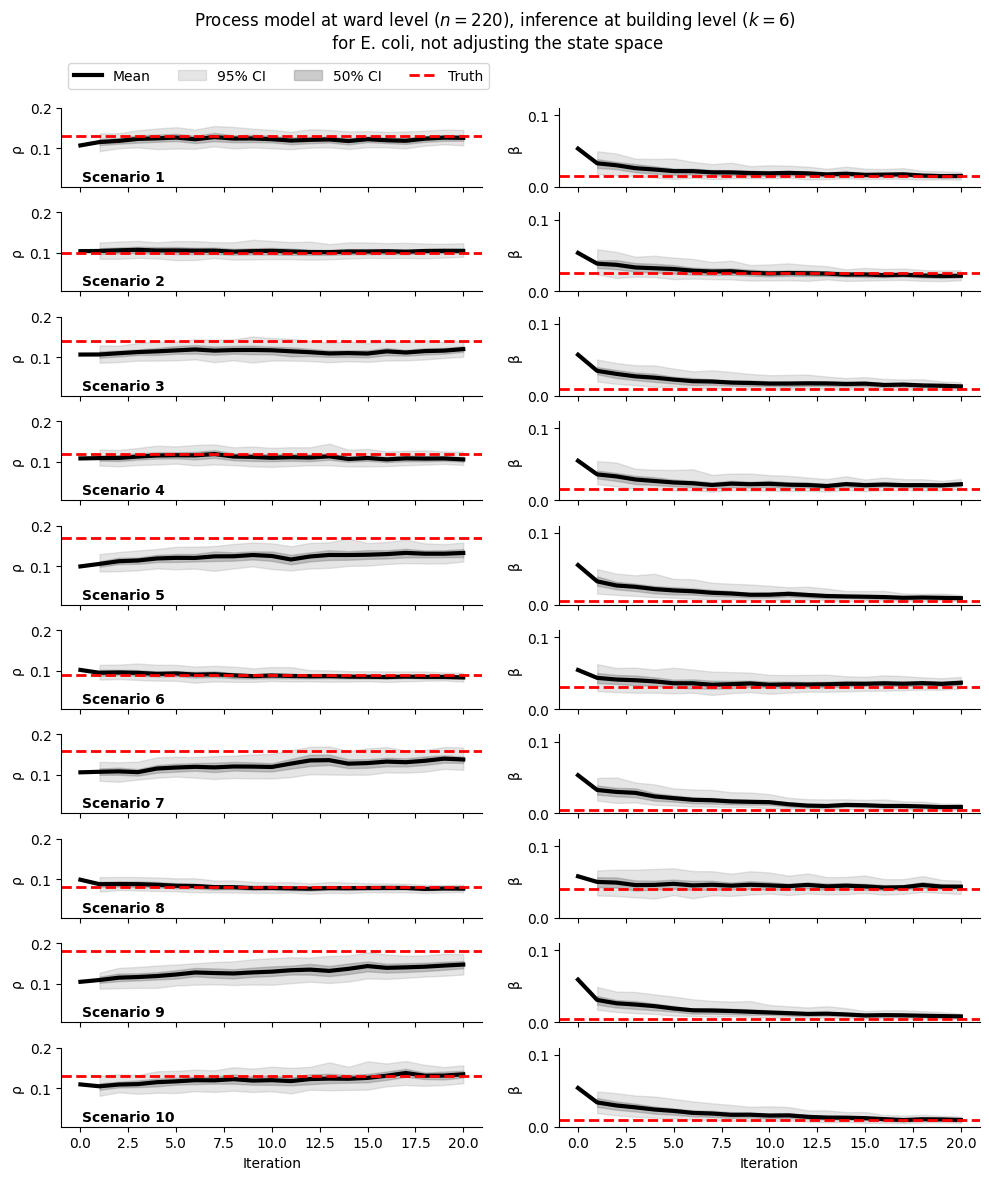

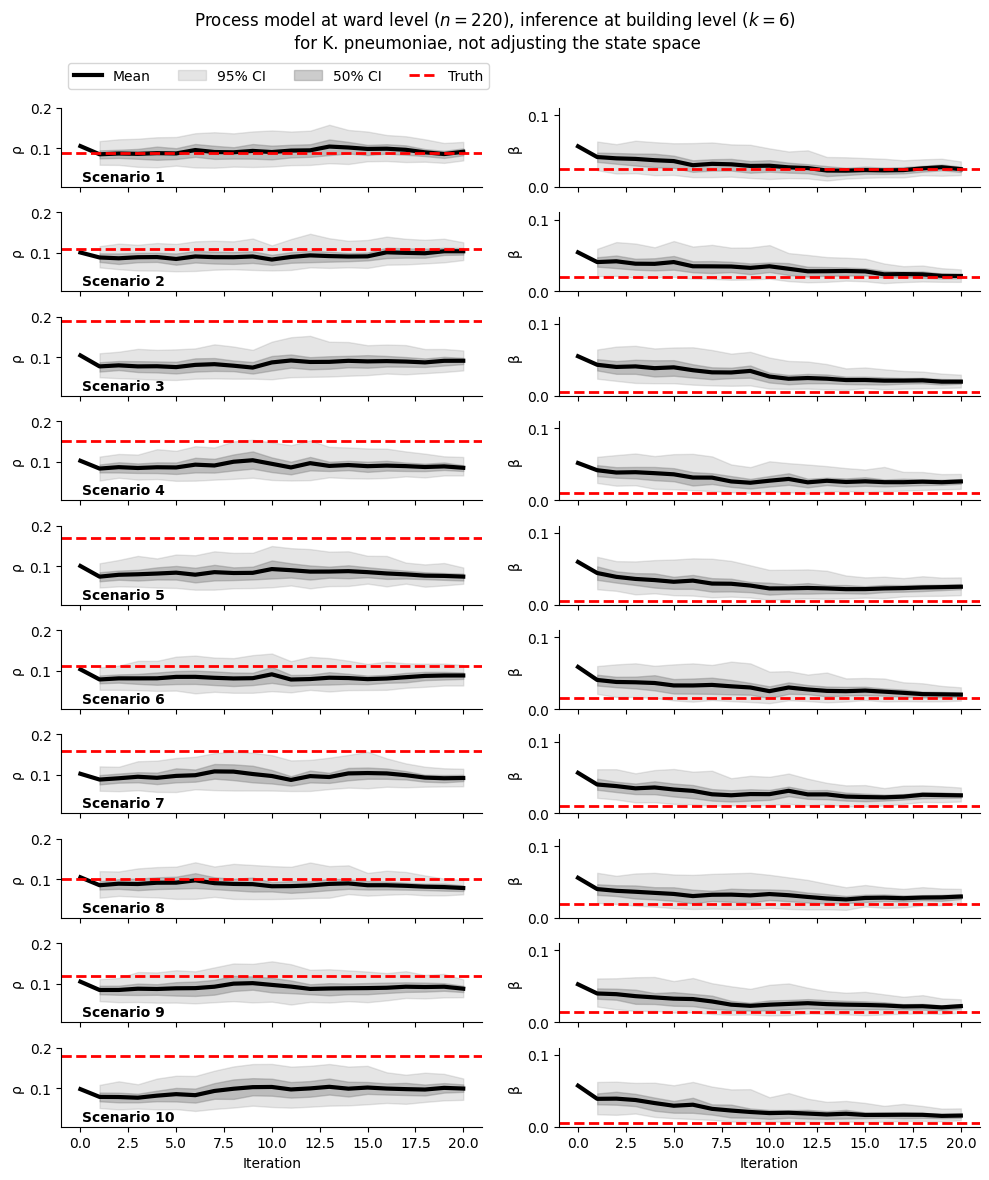

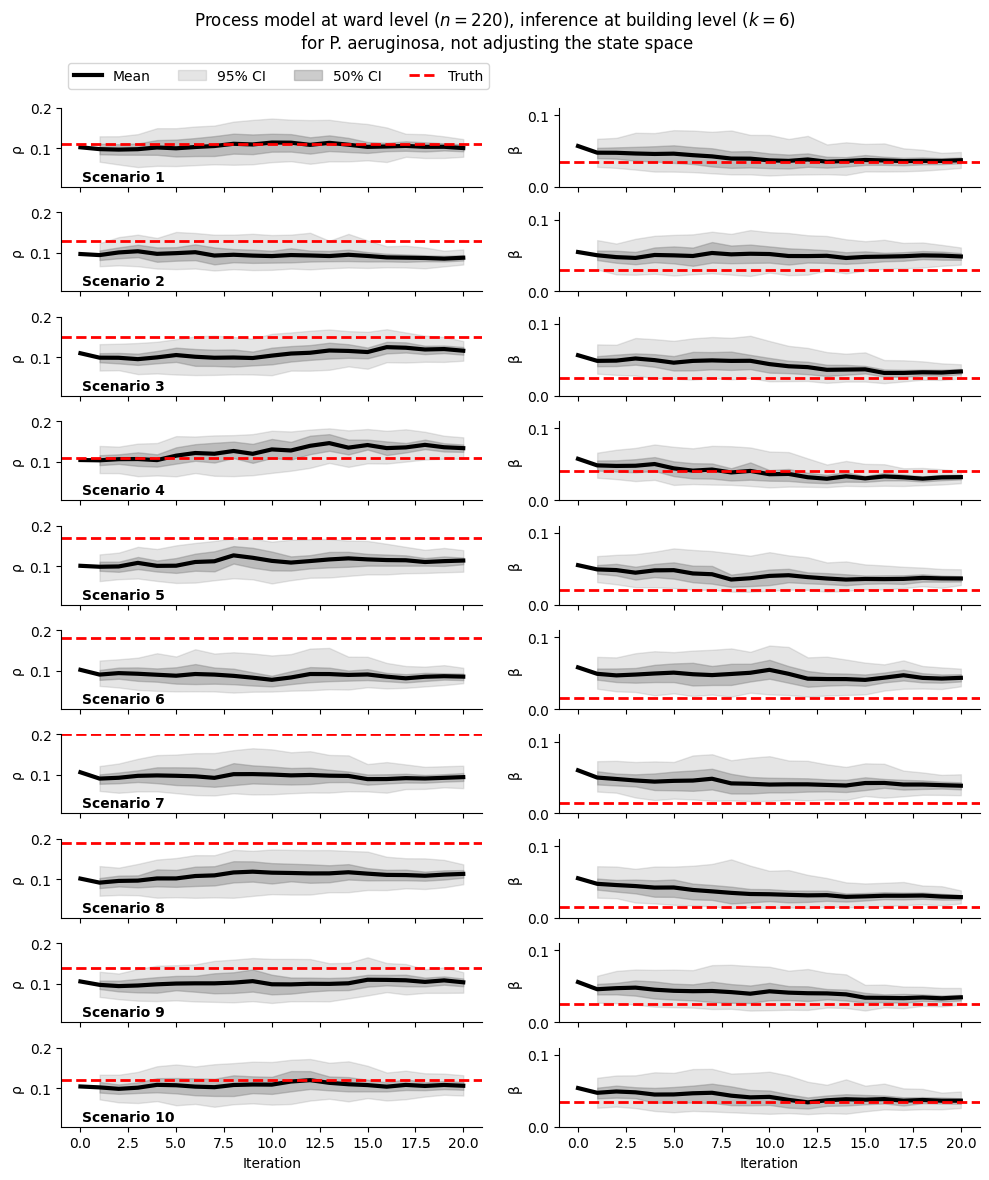

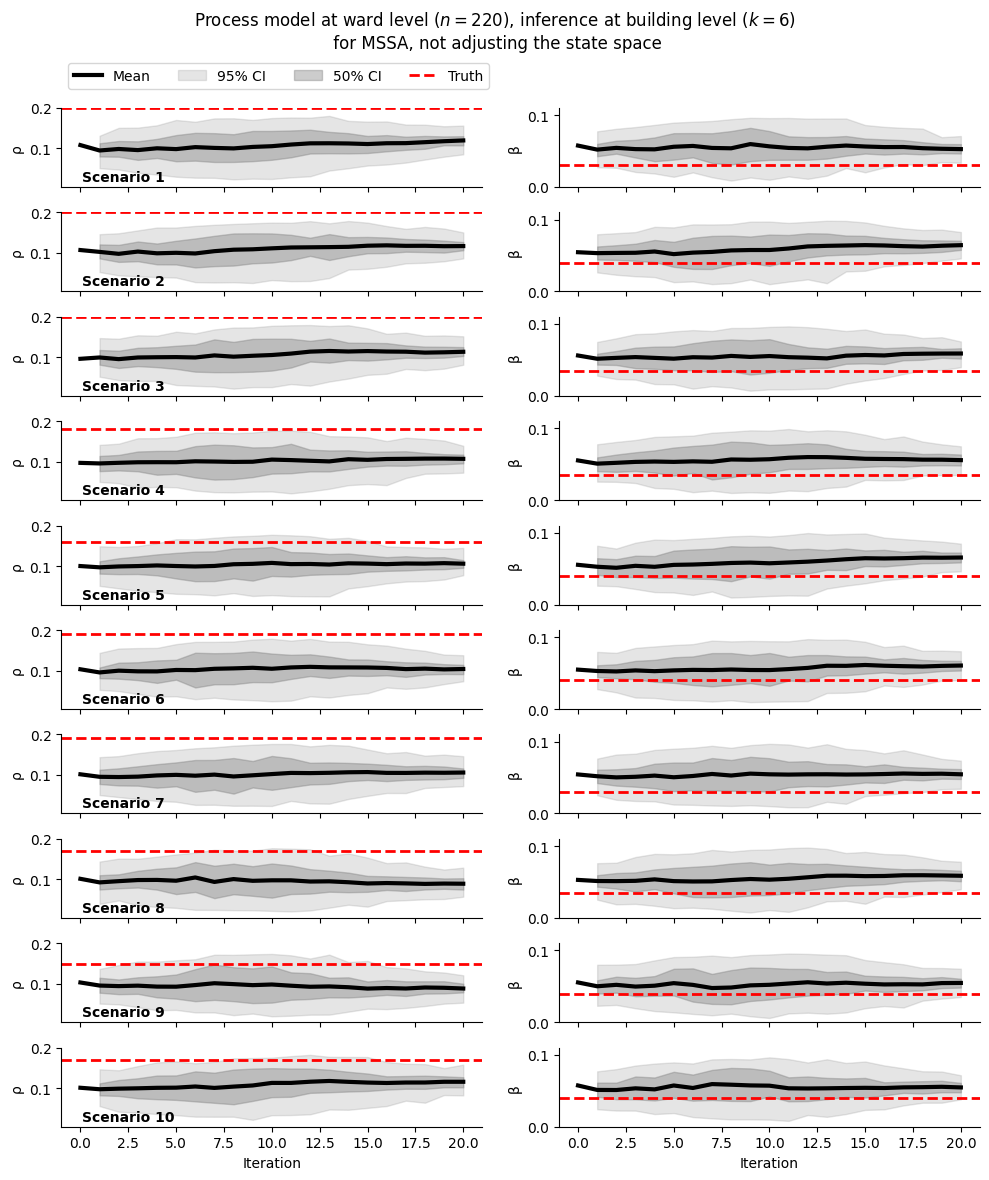

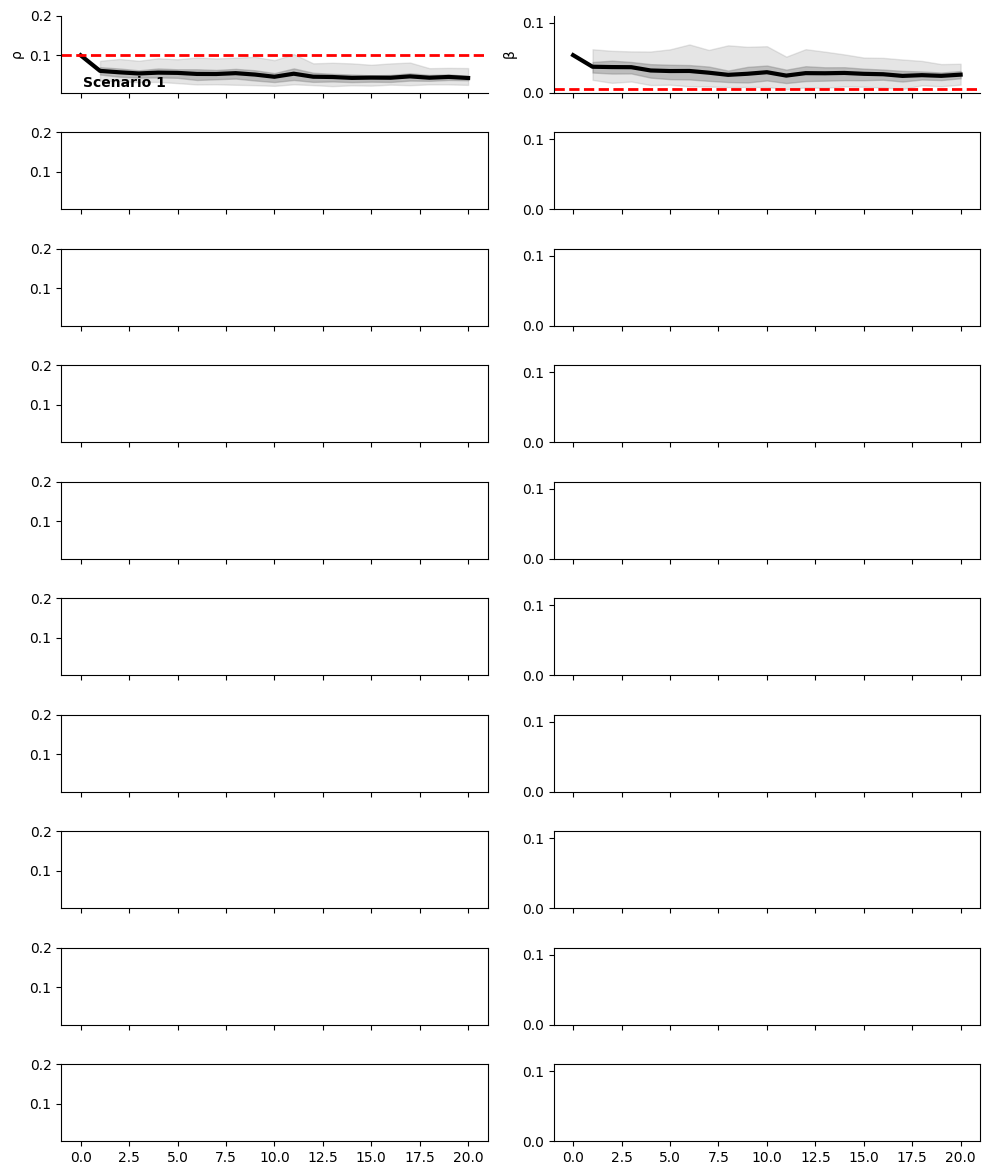

In [13]:
from utils_local.misc import amro2title, amro2cute
import matplotlib.pyplot as plt

from diagnostic_plots import convergence_plot
from utils import create_df_response

for idx_amro, amro in enumerate(amro_search):
    print("Running IF-EAKF for amro: ", amro2title(amro))
    path_to_save = os.path.join(results2_dir, "synthetic_inferences", "abm", f"{amro2cute(amro)}")
    scenarios_df = pd.read_csv(os.path.join(path_to_save, "scenarios.csv"))

    fig, axes = plt.subplots(len(scenarios_df), 2, figsize=(10, 12), sharex=True, sharey="col")
    for idx_row, row in scenarios_df.iterrows():

        inference = np.load(os.path.join(path_to_save, "infer_building",
                                        f"scenario{idx_row+1}", f"{str(0).zfill(3)}posterior.npz"))
        θmle      = inference["mle"]
        θpost     = inference["posterior"]
        y_sim     = inference["observations"]
        θtruth    = inference["teta_truth"]
        idx_infer = inference["idx_infer"]
        Nif       = θpost.shape[-1]

        ρ_df = create_df_response(θpost[0, :, :, :].mean(-2).T, time=Nif)
        β_df = create_df_response(θpost[1, :, :, :].mean(-2).T, time=Nif)

        p_dfs             = [ρ_df, β_df]
        param_label       = ["ρ", "β"]

        parameters_range  = np.array([[0.01/2, 20/100], [0, 0.11]])
        convergence_plot(θmle, p_dfs, parameters_range, param_label, ax=axes[idx_row, :], fig=fig, param_truth=list(θtruth[:, 0]))
        axes[idx_row, 0].legend().remove(); axes[idx_row, 1].legend().remove()
        axes[idx_row, 1].set_xlabel(None)

        axes[idx_row, 0].spines['right'].set_visible(False)
        axes[idx_row, 0].spines['top'].set_visible(False)

        axes[idx_row, 1].spines['right'].set_visible(False)
        axes[idx_row, 1].spines['top'].set_visible(False)
        axes[idx_row, 0].text(x=0.1, y=0.02, s=f"Scenario {idx_row+1}", weight='bold')

    axes[0, 0].legend(loc="upper left", bbox_to_anchor=(0.0, 1.65), ncol=4)
    axes[idx_row, 0].set_xlabel("Iteration")
    axes[idx_row, 1].set_xlabel("Iteration")

    fig.suptitle(f"Process model at ward level ($n=220$), inference at building level ($k=6$)\n for {amro2title(amro)}, not adjusting the state space", x=0.5)
    plt.tight_layout()
    fig.savefig(os.path.join(path_to_save, "infer_building", "convergence_plot_all.png"), dpi=300, bbox_inches="tight")

    #if amro2title(amro) == "MSSA":
    #    plt.show()
    #else:
    #    plt.close()